In [124]:
# ==================================================================
# Script to analyse tractography-related statistics
# ==================================================================
import os
import sys
import glob #for wildcard matching
import collections #for ordered dictionary
import time
import subprocess
import nibabel as nib
import numpy as np

In [125]:
"""Anthony's notes
- modules that needs to be loaded:
    - qbatch/git
    - FSL

- during the initiation of the idx and pct file paths, it is ASSUMED that all input paths will:
    - have a perfect correspondence of pct to idx paths for each subject
        - both will appear in the same ordered after being sorted in the lists
    - the second-to-last part deliminated by "/" will be the subject ID for both files
- input file path assumptions
    - there will be no period character (".") OTHER than for at the end
    - there are two total period characters: "filename.nii.gz"
"""
print "All is well"

All is well


In [134]:
# ==================================================================
# Setup files and directories
# ==================================================================

""" Note on directory hierarchy for the input, reference and transform files 
parent_dir
    |
    +-- subj_dir_1 (as indicated by dir_wc)
    |        |
    |        +- file_of_interest (as indicated by *_file_name)
    |
    +-- subj_dir_2 ...
"""

#Variable indication how many component parcellation we want to use
SEG_NUM = 10
# ========================================
# Input files for fslmaths and fslstats
# ========================================
in_parent_dir='/data/chamal/projects/anthony/nmf_parcellation/cortical_tractMap/seg'+str(SEG_NUM)+'_tract2voxel_probability_labels/model_space'
in_dir_wc='[0-9][0-9][0-9][0-9][0-9][0-9]'
idx_file_name = '*_region_seg_idx_modelSpace.nii.gz'
pct_file_name = '*_region_seg_pct_modelSpace.nii.gz' 

# ========================================
# Intermediate files
# ========================================
inter_parent_dir='/data/chamal/projects/anthony/nmf_parcellation/cortical_tractMap/seg'+str(SEG_NUM)+'_tract2voxel_probability_labels/tractAnalysis_model_space'
csvDump_filename="seg"+str(SEG_NUM)+"_avgComponentWinPct_dump.csv"

# ========================================
# JobDoc files
# ========================================
jobDoc_dir='/data/chamal/projects/anthony/qbatch_jobDocs/track_analysis_related'
jobList_path_head=os.path.join(jobDoc_dir,'autoSubmit_seg%d_tract_compWinPct'%SEG_NUM)
jobScript_stdev_name=''

In [135]:
# ==================================================================
# Initiate paths of the two input files
# ==================================================================
"""Dictionary hierarchy
subjFile_Paths
    |
    ["100307"]
    |    |
    |    ["idx"] -- path to 100307's idx file
    |    ["pct"] -- path to 100307's pct file
    |
    ["100408"]
    ...
"""
#Find all files on paths
idx_file_list=glob.glob(os.path.join(in_parent_dir,in_dir_wc,idx_file_name))
pct_file_list=glob.glob(os.path.join(in_parent_dir,in_dir_wc,pct_file_name))
#Sort the two lists
idx_file_list.sort()
pct_file_list.sort()
#Store the two files into a sorted dictionary
subjFile_paths = collections.OrderedDict([]) #Initiate ordered dictionary
for idx_file_path, pct_file_path in zip(idx_file_list, pct_file_list):
    #Store the file paths in a temp dictionary
    temp_dict = {}
    temp_dict['idx'] = idx_file_path
    temp_dict['pct'] = pct_file_path
    #Check for subject ID and that they match up
    temp_subj_ID = idx_file_path.split('/')[-2]
    if pct_file_path.split('/')[-2] != temp_subj_ID: #If the two file IDs do not match
        print "Something went wrong in the pct and idx file matching for ID: %s" % (temp_subj_ID)
    #Add the temporary dictionary to the sorted dictionary
    subjFile_paths[temp_subj_ID] = temp_dict

#Let user know 
print "The parcellation component quantity is: %d" % SEG_NUM
print "idx_file_list length: %d" % len(idx_file_list)
print "pct_file_list length: %d" % len(pct_file_list)
print "\n%d subjects were initiated into the subjFile_Paths dictionary:" % len(subjFile_paths)
for key in subjFile_paths:
    print key,
print "\n\nHopefully the above looks right!"

The parcellation component quantity is: 10
idx_file_list length: 100
pct_file_list length: 100

100 subjects were initiated into the subjFile_Paths dictionary:
100307 100408 101006 101107 101410 101915 102008 102311 102816 103111 105014 105115 105216 106016 106521 107321 107422 108121 108323 108525 109123 110411 111312 111413 111716 113215 113821 113922 114419 115320 116524 117122 118528 118730 118932 119833 120212 120515 121618 122317 122620 123117 123420 123925 124422 125525 126325 126628 127630 127933 128127 128632 129028 130013 130316 131217 131722 132118 133019 133827 134324 135225 135528 136227 136833 137027 138534 139233 140925 144832 146432 147030 147737 148840 148941 149741 150423 150524 150726 151223 151526 151627 151728 153833 154734 154835 154936 156233 156637 157437 158136 159239 159340 160830 161327 161630 162228 162733 163331 164030 

Hopefully the above looks right!


In [ ]:
"""Note on Fri, June 9
- need to write extra step to remove the thalamus mask form the tracts!

"""

In [136]:
# ==================================================================
# Generate the jobs needed to calculate everyone's component average
# ==================================================================

#Check to see if the output parent directory is present, if not create it
if os.path.isdir(inter_parent_dir):
    print "Intermediate directory found: %s" % inter_parent_dir
else:
    os.mkdir(inter_parent_dir)
    print "Intermediate directory not found, created one at: %s"% inter_parent_dir

#Create the path to the .csv file to dump all of the pct averages
csvDump_path_tail = os.path.join(inter_parent_dir, csvDump_filename)

#Create the paths to the 3 sequential files needed to get the mean
binarize_outPath = jobList_path_head + "_pt1-binarize.sub"
mul_outPath = jobList_path_head + "_pt2-multiply.sub"
avgCalc_outPath = jobList_path_head + "_pt3-calculateAverage.sub"

#Open the jobList document to write to
print "\nOpening and writing to joblist files: %s" % jobList_path
binarize_out = open(binarize_outPath, 'w')
mul_out = open(mul_outPath, 'w')
avgCalc_out = open(avgCalc_outPath, 'w')

#Lists to store all generated file paths for later reference (during auto-submission)
binarizedComp_path_list = []
pct_comp_path_list = []
indv_csv_path_list = []

#Iterate through each subject
for subj in subjFile_paths:
    #Check to see if the output directory is present, if not create it
    subj_dir_path = os.path.join(inter_parent_dir, subj)
    if not os.path.isdir(subj_dir_path):
        os.mkdir(subj_dir_path)
        
    #Generate an individual csv file for this subject
    csvDump_path = os.path.join(inter_parent_dir, str(subj)+"_indv_"+csvDump_filename)
    #Store the path to the csv file for later reference
    indv_csv_path_list.append(csvDump_path)
    
    #Get the input files
    idxPath = subjFile_paths[subj]['idx']
    pctPath = subjFile_paths[subj]['pct']
    
    #Iterate through each component
    for comp_num in range(1,SEG_NUM+1):
        #Generate the output file paths
        binarizedComp_name = idxPath.split('/')[-1].split('.')[0]+"_comp"+str(comp_num)+"_binarized.nii.gz"
        binarizedComp_outPath = os.path.join(subj_dir_path, binarizedComp_name )
        pct_comp_name = pctPath.split('/')[-1].split('.')[0]+"_comp"+str(comp_num)+".nii.gz"
        pct_comp_outPath = os.path.join(subj_dir_path, pct_comp_name )
        
        #Store the paths in reference lists
        binarizedComp_path_list.append(binarizedComp_outPath)
        pct_comp_path_list.append(pct_comp_outPath)
        
        #Generate the fsl commands
        binarization='fslmaths %s -thr %d -thr %d -bin %s' % (idxPath, comp_num,comp_num, binarizedComp_outPath)
        multiplication='fslmaths %s -mul %s %s' % (pctPath, binarizedComp_outPath, pct_comp_outPath)
        calAvg='echo "%s,%s,`fslstats %s -M`" >> %s' % (subj, "comp_"+str(comp_num), pct_comp_outPath, csvDump_path)
        
        #Write the commands to the jobList file
        binarize_out.write(binarization+"\n")
        mul_out.write(multiplication+"\n")
        avgCalc_out.write(calAvg+"\n")



#Close the jobList output stream
binarize_out.close()
mul_out.close()
avgCalc_out.close()
print "\nFinished writing to joblist file"
print "\nReference lists created:"
print "\tbinarizedComp_path_list - length: %d" % len(binarizedComp_path_list)
print "\tpct_comp_path_list - length: %d" % len(pct_comp_path_list)
print "\tindv_csv_path_list - length: %d" % len(indv_csv_path_list)

Intermediate directory not found, created one at: /data/chamal/projects/anthony/nmf_parcellation/cortical_tractMap/seg10_tract2voxel_probability_labels/tractAnalysis_model_space

Opening and writing to joblist files: /data/chamal/projects/anthony/qbatch_jobDocs/track_analysis_related/autoSubmitted_seg5_tractAnalysis.sub

Finished writing to joblist file

Reference lists created:
	binarizedComp_path_list - length: 1000
	pct_comp_path_list - length: 1000
	indv_csv_path_list - length: 100


In [137]:
# ==================================================================
# Optionally submit the job sequentially to the cluster
# ==================================================================

######## Qbatch specifics ########
SUBMIT = True
#For the 1st and 2nd job (normal)
CHUNKSIZE = '1' #Need each 3 lines to run sequentially
WALLTIME = '00:30:00'
#For the 3rd job
CHUNKSIZE_3 = str(SEG_NUM) #Each job will be for individual subjects
PPJ_3 = "4" #Needs more memory than usual
"""This should take ~2min per line, so each job should be SEG_NUM*2min long? (guesstimated, may be shorter)"""


#Function to wait until the previous step has been completed
def waitLoop(prev_output_paths):
    #Infinite loop
    while True:
        #Check if all output files from previous step is present
        allFilesPresent = True
        for path in prev_output_paths:
            if os.path.isfile(path) != True:
                allFilesPresent = False
        #Either break loop or continue waiting
        if allFilesPresent:
            break
        else:
            time.sleep(5) #Currently checks every 5 seconds
    print "All output files from previous step found!"
            
            
#Automatically submit all 3 jobList files sequentially
if SUBMIT:
    ######## Step 1: submit the binarization files ########
    print "Submitting binarization job (step 1):"
    cmd = ['qbatch','-w',WALLTIME, '-c',CHUNKSIZE, binarize_outPath]
    print ' '.join(cmd)
    subprocess.call(cmd)
    
    ####### Step 2: submit the multiplciation files #######
    #Wait until the previous jobs have been completed
    print "\nWaiting for step 1 to finish..."
    waitLoop(binarizedComp_path_list)
    #Submit step 2
    print "\nSubmitting multiplication job (step 2):"
    cmd = ['qbatch','-w',WALLTIME, '-c',CHUNKSIZE, mul_outPath]
    print ' '.join(cmd)
    subprocess.call(cmd)
    
    sys.exit() #TODO: temp solution because the last steps always messes up
                #Will do last submission locally manually
    
    ####### Step 3: submit the fslstats average calculation #######
    #Wait until the previous jobs have been completed
    print "\nWaiting for step 2 to finish..."
    waitLoop(pct_comp_path_list)
    #Submit step 3
    print "\nSubmitting average calculation job (step 3):"
    cmd = ['qbatch', '-c', CHUNKSIZE_3, '--ppj', PPJ_3, avgCalc_outPath]
    print ' '.join(cmd)
    subprocess.call(cmd)
    print
else:
    print "Auto-submit not enabled. Skipping over current code block."
    

print "Done"    

Submitting binarization job (step 1):
qbatch -w 00:30:00 -c 1 /data/chamal/projects/anthony/qbatch_jobDocs/track_analysis_related/autoSubmit_seg10_tract_compWinPct_pt1-binarize.sub

Waiting for step 1 to finish...
All output files from previous step found!

Submitting multiplication job (step 2):
qbatch -w 00:30:00 -c 1 /data/chamal/projects/anthony/qbatch_jobDocs/track_analysis_related/autoSubmit_seg10_tract_compWinPct_pt2-multiply.sub


SystemExit: 

In [97]:
####################################################################
# ==================================================================
""" =================== DEPENDENCY SEPARATOR =================== """
# ==================================================================
####################################################################
print "The below block is independent, other than for the first (module import) block"

The below block is independent, other than for the first (module import) block


In [117]:
# ==================================================================
# Set up input directories and paths
# *currently dependent on the prev file input block
# *can simply take away the right-hand-side variables for manual input
# ==================================================================
"""Notes on file formats
- The 2nd col of the .csv file ALWAYS specifies the component #
    - Specified as a string
    - Needs to be the same for all subj's same components
- The 3rd col of the .csv file ALWAYS specifies the mean
    - It needs to be able to be converted to a float
"""
#Additional imports
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#specify parcellation quantity
SEG_NUM = 6

#Paths set-up
indv_csv_dir = '/data/chamal/projects/anthony/nmf_parcellation/cortical_tractMap/seg'+str(SEG_NUM)+'_tract2voxel_probability_labels/tractAnalysis_model_space'
indv_csv_wc = "*seg"+str(SEG_NUM)+"_avgComponentWinPct_dump.csv"

# ==================================================================
# Find and initiate input files
# ==================================================================

#Locate and sort file paths 
indv_csv_paths = glob.glob(os.path.join(indv_csv_dir, indv_csv_wc))
indv_csv_paths.sort()

print "File paths found: %d" % len(indv_csv_paths)
print "\nFirst path is: %s" % indv_csv_paths[0]
print "\nLast path is: %s" % indv_csv_paths[-1]

File paths found: 0


IndexError: list index out of range

In [115]:
# ==================================================================
# Find and initiate input files
# ==================================================================
"""Variable hierarchy
tractWinPct
    |
    [0]-- component 1's tract win pct
            (this is a list of average winPct in float)
"""

#Initiate a dictionary 
tractWinPct_unordered = {}

#Iterate through each subject's csv file
print "Initiating .csv file contents..."
for csv_path in indv_csv_paths:
    #Open the file and initate reader
    csvfile = open(csv_path, 'rb')
    reader = csv.reader(csvfile)
    #Iterate through each row of the csv file
    for row in reader:
        #If the component num has not been initiated, initiate the key
        if row[1] not in tractWinPct_unordered:
            tractWinPct_unordered[row[1]] = [float(row[2])]
        #Else, concatenate the mean onto the list
        else:
            tractWinPct_unordered[row[1]].append(float(row[2]))

#Initiate a sorted dictionary
print "Sorting component lexographically..."
tractWinPct = collections.OrderedDict(sorted(tractWinPct_unordered.items()))

#Let user know
print "\nDone. Below are the components and length of lists for each:"
for key in tractWinPct:
    print "\t%s\tLength: %d" % (key, len(tractWinPct[key]))

Initiating .csv file contents...
Sorting component lexographically...

Done. Below are the components and length of lists for each:
	comp_1	Length: 100
	comp_2	Length: 100
	comp_3	Length: 100
	comp_4	Length: 100
	comp_5	Length: 100


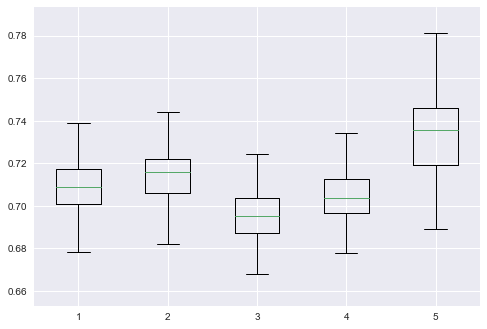

In [116]:
# ==================================================================
# Plots and shit
# ==================================================================
data = []
for key in tractWinPct:
    data.append(tractWinPct[key])

plt.figure()
plt.boxplot(data)
plt.show()